In [65]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [66]:
N = 200

X = np.random.uniform(low=-50, high=50, size=(N, 2))
T = X@np.array([[3.2],[-5]]) + np.random.normal(size=(N, 1), scale=5.5)
T.shape, X.shape

((200, 1), (200, 2))

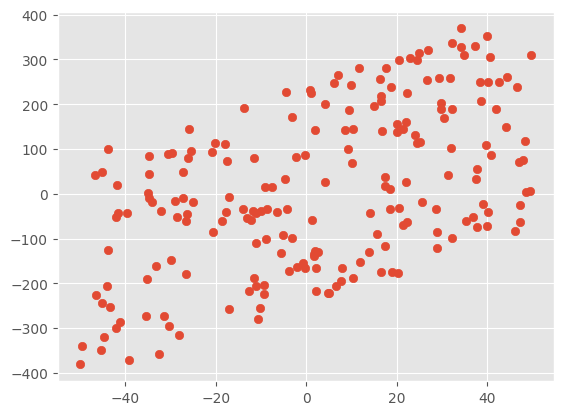

In [67]:
plt.scatter(X[:,:1],T)

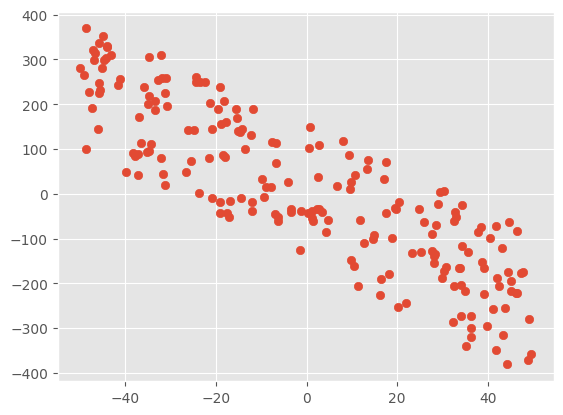

In [68]:
plt.scatter(X[:,1],T)

In [69]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) - (0.5 * (1/(std**2))* (x-mu)**2)

In [70]:
class MCElbo(torch.nn.Module):
    def __init__(self,
                 in_features,
                 out_features):
        super(MCElbo, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        self.in_features = in_features
        self.out_features = out_features
        
        #The parameters we adjust during training.
        self.qm = torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)
        self.qs= torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_m = Variable(torch.randn(in_features,out_features), requires_grad=False)
        self.prior_s = Variable(torch.randn(in_features,out_features), requires_grad=False)
        self.likelihood_s = Variable(torch.FloatTensor((1)), requires_grad=False)
        
        #Set the prior and likelihood moments.
        self.prior_s.data.fill_(1.0)
        self.prior_m.data.fill_(0.9)
        self.likelihood_s.data.fill_(5.5)
     
        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,self.in_features,self.out_features))
    
    def reparam(self, eps):
        eps = Variable(torch.FloatTensor(eps))
        return  (eps*self.softplus(self.qs)).add(self.qm)
    
    def compute_elbo(self, x, t):
        eps = self.generate_rand()
        z = self.reparam(eps)

        q_likelihood = log_norm(z, self.qm, self.softplus(self.qs))
        q_likelihood = torch.mean(q_likelihood)

        prior = log_norm(z, self.prior_m, self.prior_s)
        prior = torch.mean(prior)

        preds = torch.einsum("ij,kjl->kil",x,z)
        likelihood = torch.mean(torch.sum(log_norm(t, preds, self.likelihood_s), 0))
        
        kld_mc = q_likelihood - prior
        loss = likelihood - kld_mc
        return loss

In [71]:
x = torch.randn(10,2)
z = torch.randn(5,2,1)
res = torch.einsum("ij,kjl->kil",x,z)

for k in range(z.size(0)):
    for i in range(x.size(0)):
        res_man = x[i] @ z[k]
        assert torch.allclose(res[k,i],res_man)



In [72]:
c = MCElbo(2,1)
optimizer = torch.optim.Adam(c.parameters(),lr=0.2)
x = Variable(torch.Tensor(X), requires_grad=False) 
t = Variable(torch.Tensor(T), requires_grad=False)

for i in range(3000):
    loss = -c.compute_elbo(x, t)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    if i % 250 ==0:
        print(c.qm.data.numpy(), (c.softplus(c.qs).data**2).numpy())

[[ 0.43854836]
 [-0.58015984]] [[0.40404892]
 [0.7630541 ]]
[[ 3.190287]
 [-4.99504 ]] [[0.00046501]
 [0.00078995]]
[[ 3.1902413]
 [-4.994546 ]] [[0.00026846]
 [0.0003638 ]]
[[ 3.1884854]
 [-4.995896 ]] [[0.00021213]
 [0.00024591]]
[[ 3.1894906]
 [-4.994545 ]] [[0.00019992]
 [0.00020258]]
[[ 3.1915205]
 [-4.995319 ]] [[0.00019504]
 [0.00018063]]
[[ 3.1918871]
 [-4.9961734]] [[0.00019592]
 [0.00017176]]
[[ 3.1915746]
 [-4.995202 ]] [[0.00019732]
 [0.00016506]]
[[ 3.192295 ]
 [-4.9949574]] [[0.00019983]
 [0.00016349]]
[[ 3.189709 ]
 [-4.9961367]] [[0.0001979 ]
 [0.00016447]]
[[ 3.1905336]
 [-4.9986515]] [[0.00019386]
 [0.00016489]]
[[ 3.1894286]
 [-4.9953957]] [[0.00019301]
 [0.00016523]]


In [73]:
analytical_posterior_var = ((1/5.5**2)*X.T@ X +1)**-1
analytical_posterior_var, c.softplus(c.qs).data.numpy()**2

(array([[ 0.00019517, -0.00565332],
        [-0.00565332,  0.00016429]]),
 array([[0.00019361],
        [0.00016567]], dtype=float32))

In [74]:
X.T @ T

array([[ 521292.41475495],
       [-937021.29912617]])

In [75]:
analytical_posterior_mean = analytical_posterior_var@(0.9+((1/5.5**2)*X.T @ T))
analytical_posterior_mean, c.qm.data.numpy()

(array([[ 178.47493554],
        [-102.51631735]]),
 array([[ 3.1897924],
        [-4.9953456]], dtype=float32))

In [76]:
analytical_posterior_mean.shape

(2, 1)

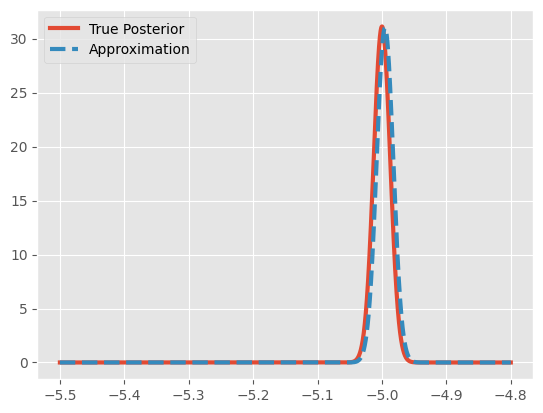

In [77]:
from scipy.stats import norm
param_in, param_out = 1,0
xn = np.arange(-5.5, -4.8, 0.0001)
true_dist = norm(loc = -5, 
                 scale =(analytical_posterior_var[param_in, param_in])**0.5)
q_dist = norm(loc = c.qm[param_in, param_out].data.numpy(), scale = c.softplus(c.qs[param_in, param_out]).data.numpy())
yn = true_dist.pdf(xn).ravel()
plt.plot(xn, yn, linewidth=3, label="True Posterior")
plt.plot(xn, q_dist.pdf(xn).ravel(), '--', linewidth=3,
         label="Approximation")
plt.legend()

In [78]:
yn

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       5.34586629e-52, 4.73354994e-52, 4.19111328e-52])